In [68]:
import pandas as pd
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [69]:
df = pd.read_csv("../data/processed/train/data.csv", low_memory=False)
df_val = pd.read_csv("../data/processed/val/data.csv", low_memory=False)
df.head()

,file,superflux,timestamps,superflux.diff,superflux.ewm3,superflux.diff.ewm3,superflux.ewm6,superflux.diff.ewm6,energy,energy.diff,...,skew.diff.ewm3,skew.ewm6,skew.diff.ewm6,std,std.diff,std.ewm3,std.diff.ewm3,std.ewm6,std.diff.ewm6,onset
0,Media-103611(8.2-18.2),0.00000,0.025,NaN,0.00000,NaN,0.00000,NaN,4.357543e+10,NaN,...,NaN,0.10405,NaN,0.21315,NaN,0.00884,NaN,-0.00499,NaN,False
1,Media-103611(8.2-18.2),0.01709,0.075,0.05491,0.00271,0.05560,0.00002,0.00002,3.027467e+10,8.087514e+10,...,0.14014,0.04150,-0.01587,0.00680,13.79275,0.00703,133.84082,0.00678,57.37891,False
2,Media-103611(8.2-18.2),0.03226,0.125,0.20353,0.00231,-0.00793,0.00831,0.00001,4.889006e+10,-5.618729e+08,...,0.08917,0.02014,-0.09187,4.48390,-2.81474,0.16382,93.08572,0.01077,-0.17519,False
3,Media-103611(8.2-18.2),0.01570,0.175,-0.25222,0.00342,0.03699,0.03620,0.00000,1.273764e+11,-3.511251e+10,...,0.06095,0.01771,-0.09991,-44.78118,-33.81452,10.59000,-32.58283,-2.62855,-0.45760,True
4,Media-103611(8.2-18.2),0.08049,0.225,0.01040,0.00273,-0.02372,0.03039,0.00012,2.027606e+11,1.365240e+10,...,-0.02018,0.00782,0.02715,-43.03605,5.66304,23.63310,23.70116,-14.65090,16.54490,False


In [71]:
df = pd.concat([df, df_val])
df["onset"] = df["onset"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48899 entries, 0 to 9247
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   file                 48899 non-null  object  
 1   superflux            48899 non-null  float64 
 2   timestamps           48899 non-null  float64 
 3   superflux.diff       48772 non-null  float64 
 4   superflux.ewm3       48899 non-null  float64 
 5   superflux.diff.ewm3  48772 non-null  float64 
 6   superflux.ewm6       48899 non-null  float64 
 7   superflux.diff.ewm6  48772 non-null  float64 
 8   energy               48899 non-null  float64 
 9   energy.diff          48772 non-null  float64 
 10  energy.ewm3          48899 non-null  float64 
 11  energy.diff.ewm3     48772 non-null  float64 
 12  energy.ewm6          48899 non-null  float64 
 13  energy.diff.ewm6     48772 non-null  float64 
 14  rms                  48899 non-null  float64 
 15  rms.diff            

In [72]:
train_len = len(df)
splits = (list(range_of(df)[:train_len]), list(range_of(df)[train_len:]))

In [73]:
procs = [Categorify, FillMissing, Normalize]

In [74]:
cont, cat = cont_cat_split(
    df.loc[:, ~df.columns.isin(["file", "timestamps"])], 1, dep_var="onset"
)

In [75]:
cont

['superflux',
 'superflux.diff',
 'superflux.ewm3',
 'superflux.diff.ewm3',
 'superflux.ewm6',
 'superflux.diff.ewm6',
 'energy',
 'energy.diff',
 'energy.ewm3',
 'energy.diff.ewm3',
 'energy.ewm6',
 'energy.diff.ewm6',
 'rms',
 'rms.diff',
 'rms.ewm3',
 'rms.diff.ewm3',
 'rms.ewm6',
 'rms.diff.ewm6',
 'welch',
 'welch.diff',
 'welch.ewm3',
 'welch.diff.ewm3',
 'welch.ewm6',
 'welch.diff.ewm6',
 'mean',
 'mean.diff',
 'mean.ewm3',
 'mean.diff.ewm3',
 'mean.ewm6',
 'mean.diff.ewm6',
 'kurtosis',
 'kurtosis.diff',
 'kurtosis.ewm3',
 'kurtosis.diff.ewm3',
 'kurtosis.ewm6',
 'kurtosis.diff.ewm6',
 'skew',
 'skew.diff',
 'skew.ewm3',
 'skew.diff.ewm3',
 'skew.ewm6',
 'skew.diff.ewm6',
 'std',
 'std.diff',
 'std.ewm3',
 'std.diff.ewm3',
 'std.ewm6',
 'std.diff.ewm6']

In [76]:
cat

[]

In [77]:
dls = TabularDataLoaders.from_df(
    df,
    y_names="onset",
    cat_names=cat,
    cont_names=cont,
    procs=procs,
    splits=splits,
    bs=128,
)

In [78]:
dls.show_batch()

,superflux.diff_na,superflux.diff.ewm3_na,superflux.diff.ewm6_na,energy.diff_na,energy.diff.ewm3_na,energy.diff.ewm6_na,rms.diff_na,rms.diff.ewm3_na,rms.diff.ewm6_na,welch.diff_na,welch.diff.ewm3_na,welch.diff.ewm6_na,mean.diff_na,mean.diff.ewm3_na,mean.diff.ewm6_na,kurtosis.diff_na,kurtosis.diff.ewm3_na,kurtosis.diff.ewm6_na,skew.diff_na,skew.diff.ewm3_na,skew.diff.ewm6_na,std.diff_na,std.diff.ewm3_na,std.diff.ewm6_na,superflux,superflux.diff,superflux.ewm3,superflux.diff.ewm3,superflux.ewm6,superflux.diff.ewm6,energy,energy.diff,energy.ewm3,energy.diff.ewm3,energy.ewm6,energy.diff.ewm6,rms,rms.diff,rms.ewm3,rms.diff.ewm3,rms.ewm6,rms.diff.ewm6,welch,welch.diff,welch.ewm3,welch.diff.ewm3,welch.ewm6,welch.diff.ewm6,mean,mean.diff,mean.ewm3,mean.diff.ewm3,mean.ewm6,mean.diff.ewm6,kurtosis,kurtosis.diff,kurtosis.ewm3,kurtosis.diff.ewm3,kurtosis.ewm6,kurtosis.diff.ewm6,skew,skew.diff,skew.ewm3,skew.diff.ewm3,skew.ewm6,skew.diff.ewm6,std,std.diff,std.ewm3,std.diff.ewm3,std.ewm6,std.diff.ewm6,onset
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.00420,3.168535e-12,0.07813,-0.01446,0.01582,-0.02482,2.721943e+10,-7.058631e+10,1.283201e+11,6.850538e+09,2.320235e+10,-1.541037e+09,3834.792723,121.826168,11342.941994,-256.828722,3039.018565,-175.067274,1.960562e+07,1.840120e+05,1.503264e+07,-8.080375e+06,1.180828e+07,-3.034082e+06,-14.437641,-57.350339,-81.636436,-31.812181,-6.013121,-41.770031,-0.15453,0.136920,0.26923,0.30140,0.85338,0.01687,0.14732,0.08996,-0.10862,-0.02529,-0.11279,-0.05837,-219.147162,-46.631289,19.913080,-144.368795,33.928632,-23.821500,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.01172,9.330000e-03,0.03496,-0.00770,0.11938,-0.00445,3.427865e+10,3.822741e+10,1.425996e+10,3.826456e+10,3.113642e+11,-2.696531e+10,1661.511666,12.823788,5377.145972,-261.903288,2317.522739,-728.180677,9.256524e+06,-1.077839e+07,8.612488e+06,7.917175e+06,1.873907e+07,-1.561234e+05,-88.548746,0.001580,128.900358,-25.013942,12.189041,-14.566920,-0.16134,-0.235910,0.96277,-0.06908,-0.68304,-0.11038,-0.71060,0.13664,-0.80364,0.05103,-0.04645,-0.06665,3.527440,23.712250,-203.571800,34.821547,-50.558575,25.502412,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.09333,-3.360000e-03,0.11261,-0.02224,0.02392,-0.00389,2.795297e+11,-1.264137e+09,3.907860e+08,-1.111239e+10,4.909486e+10,1.590558e+10,1488.033639,-879.835212,1162.662449,291.829498,1658.819763,-106.157009,7.220046e+07,-4.834476e+06,6.277814e+07,5.629549e+06,2.017877e+06,-1.368292e+06,149.898409,-119.927223,-13.201550,-24.648702,-169.638193,2.985200,-0.40175,11.931579,-0.35340,-0.27361,0.09599,-0.45349,-0.02209,0.16663,-0.11185,0.08432,0.04917,0.01153,12.560770,111.952606,5.169830,30.430431,146.154781,-14.430700,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.02674,2.800000e-03,0.01738,0.00011,0.02480,-0.00205,1.504486e+09,6.241876e+09,2.598794e+11,5.599946e+10,7.071276e+10,9.409179e+09,3986.823976,-90.833981,2098.561311,-24.524890,4006.199461,-148.308544,5.445449e-01,1.791237e+06,5.422873e+07,1.109616e+07,-3.943565e-01,1.176765e+06,-6.041720,-8.714060,-46.002318,86.913330,-7.095009,-3.379580,-0.39017,1.052980,0.06532,0.03246,-0.06366,0.04914,0.12939,0.05561,-0.11569,0.04889,0.01631,-0.02352,-4.461450,111.770075,8.474940,62.781962,3.558880,-38.348979,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.00830,5.330000e-03,0.01132,-0.00181,0.01664,-0.00869,9.988832e+09,-9.488072e+09,2.335086e+11,3.565982e+09,3.199177e+10,4.728912e+09,5206.463839,-0.004120,4789.666486,973.625305,831

In [79]:
#####################
# Construct Weights #
#####################
class_count_df = df.groupby("onset").count()

n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)

# Important: Convert Weights To Float Tensor
class_weights = torch.FloatTensor([w_0, w_1])

In [80]:
class_weights

tensor([0.6846, 1.8545])

In [81]:
loss_func = LabelSmoothingCrossEntropyFlat(weight=class_weights)
# loss_func = LabelSmoothingCrossEntropy()
# loss_func = FocalLossFlat(weight=class_weights)

In [82]:
learn = tabular_learner(
    dls,
    loss_func=loss_func,
    opt_func=Lamb,
    layers=[512, 256, 256, 128, 64],
    config=tabular_config(ps=[0.25, 0.2, 0.15, 0.1, 0.05], act_cls=Mish(inplace=True)),
    metrics=[
        accuracy,
        F1Score(labels=[0, 1]),
        Precision(labels=[0, 1]),
        Recall(labels=[0, 1]),
    ],
)

In [83]:
learn.summary()

TabularModel (Input shape: 128 x 24)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 3             
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                

SuggestedLRs(valley=0.0063095735386013985)

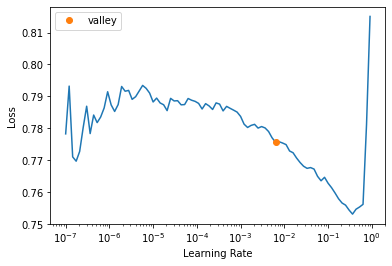

In [84]:
learn.lr_find()

In [85]:
learn.fit_one_cycle(4, 6e-3, wd=1e-5)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.701236,0.697774,0.513243,0.367190,0.282992,0.522710,00:25
1,0.691899,0.695031,0.475202,0.378090,0.278075,0.590462,00:24
2,0.691649,0.691680,0.570406,0.349388,0.295675,0.426949,00:14
3,0.689158,0.691517,0.494120,0.392634,0.290569,0.605223,00:16


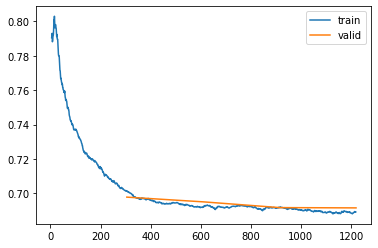

In [86]:
learn.recorder.plot_loss()

In [87]:
learn.show_results()

,superflux.diff_na,superflux.diff.ewm3_na,superflux.diff.ewm6_na,energy.diff_na,energy.diff.ewm3_na,energy.diff.ewm6_na,rms.diff_na,rms.diff.ewm3_na,rms.diff.ewm6_na,welch.diff_na,welch.diff.ewm3_na,welch.diff.ewm6_na,mean.diff_na,mean.diff.ewm3_na,mean.diff.ewm6_na,kurtosis.diff_na,kurtosis.diff.ewm3_na,kurtosis.diff.ewm6_na,skew.diff_na,skew.diff.ewm3_na,skew.diff.ewm6_na,std.diff_na,std.diff.ewm3_na,std.diff.ewm6_na,superflux,superflux.diff,superflux.ewm3,superflux.diff.ewm3,superflux.ewm6,superflux.diff.ewm6,energy,energy.diff,energy.ewm3,energy.diff.ewm3,energy.ewm6,energy.diff.ewm6,rms,rms.diff,rms.ewm3,rms.diff.ewm3,rms.ewm6,rms.diff.ewm6,welch,welch.diff,welch.ewm3,welch.diff.ewm3,welch.ewm6,welch.diff.ewm6,mean,mean.diff,mean.ewm3,mean.diff.ewm3,mean.ewm6,mean.diff.ewm6,kurtosis,kurtosis.diff,kurtosis.ewm3,kurtosis.diff.ewm3,kurtosis.ewm6,kurtosis.diff.ewm6,skew,skew.diff,skew.ewm3,skew.diff.ewm3,skew.ewm6,skew.diff.ewm6,std,std.diff,std.ewm3,std.diff.ewm3,std.ewm6,std.diff.ewm6,onset,onset_pred
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.507046,0.034187,0.127476,-0.836639,1.096827,-0.007676,-0.778701,0.453721,-0.785329,-0.261052,-0.267706,-0.000453,-0.838080,-0.175189,-0.171793,0.714538,-0.164838,-0.047824,-0.514933,-0.002322,-0.901234,0.309979,0.413697,-0.570369,0.175658,-0.120583,-0.593722,0.266032,-0.117039,-0.460936,-0.036160,-0.025184,-0.049915,-0.013105,-0.060914,-0.002693,-0.096664,0.113803,0.127355,0.051882,-0.228038,0.007305,-0.032595,-0.384262,0.339058,-0.042599,0.195691,-0.027542,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.502642,-0.029935,0.065786,-0.844464,0.079957,0.240147,2.119460,0.393370,-0.858422,0.691515,-0.773704,-0.096767,0.874438,1.136379,-0.179128,0.203841,0.781840,0.435666,-0.450959,-0.231283,1.035231,-0.075764,1.135028,-0.001375,-0.932839,-0.115771,-0.084135,0.316345,-0.146055,0.311656,-0.029979,-0.025173,-0.044478,0.005370,-0.051694,-0.002837,-0.063497,-0.047999,-0.140149,-0.181543,0.057215,0.034258,-0.318130,-0.257853,-0.058663,0.142866,-0.401477,-2.812070,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.083713,0.187629,3.744087,-1.264155,-0.765654,0.005778,-0.751287,0.116813,0.509843,1.805897,1.270949,5.203429,-0.977841,-0.345489,-0.342930,-0.072178,-0.871634,0.072315,-0.507663,-0.207704,-0.877291,0.718757,-0.827382,0.540631,-0.297031,-0.044666,0.289769,-1.061877,7.866820,-0.020385,-0.043135,-0.021711,-0.025277,-0.001812,-0.047771,-0.002853,0.063509,-0.108975,-0.041075,-0.158495,-0.378336,-0.050289,-0.553994,-0.060436,0.090174,0.039851,0.029862,0.319148,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.572160,-0.027876,-0.863615,0.000609,-0.271360,-0.471206,3.118840,2.682247,2.872135,0.006190,-0.290945,-0.116516,-0.468965,-0.060255,0.056445,-0.933549,-0.623405,0.083242,-0.767416,-0.886137,0.150574,-0.169420,2.803518,6.610159,-0.717382,-0.026999,0.958448,0.394590,2.498956,-0.161031,-0.038620,-0.030735,-0.036538,-0.021236,-0.045907,-0.006403,0.035575,-0.002962,0.028688,-0.015542,0.013713,-0.046200,-0.397029,0.158807,-0.063889,-0.692555,-0.456629,0.330752,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.515115,-1.247276,-0.435595,0.671166,0.552569,-0.081893,-0.673435,-0.724301,-0.698043,-0.010763,0.262151,-0.407512,-0.673232,0.072083,0.403519,0.821089,-0.651466,-0.564888,0.780962,1.375531,-0.590859,-0.035412,-0.487868,-0.341984,0.194420,-0.393570,-0.574219,1.278130,-1.215031,-0.160610,-0.035451,-0.026431,0.033092,-0.015007,-0.050476,-0.002579,0.036786,0.010024,0.104397,0.092362,0.159506,-0.055159,-0.588150,-0.113420,0.212966,-2.485129,0.020965,-0.590539,0.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.508298,-0.388490,-0.729278,-0.105381,-0

In [88]:
interp = ClassificationInterpretation.from_learner(learn)
interp.show_results(list(range(8)))

,superflux.diff_na,superflux.diff.ewm3_na,superflux.diff.ewm6_na,energy.diff_na,energy.diff.ewm3_na,energy.diff.ewm6_na,rms.diff_na,rms.diff.ewm3_na,rms.diff.ewm6_na,welch.diff_na,welch.diff.ewm3_na,welch.diff.ewm6_na,mean.diff_na,mean.diff.ewm3_na,mean.diff.ewm6_na,kurtosis.diff_na,kurtosis.diff.ewm3_na,kurtosis.diff.ewm6_na,skew.diff_na,skew.diff.ewm3_na,skew.diff.ewm6_na,std.diff_na,std.diff.ewm3_na,std.diff.ewm6_na,superflux,superflux.diff,superflux.ewm3,superflux.diff.ewm3,superflux.ewm6,superflux.diff.ewm6,energy,energy.diff,energy.ewm3,energy.diff.ewm3,energy.ewm6,energy.diff.ewm6,rms,rms.diff,rms.ewm3,rms.diff.ewm3,rms.ewm6,rms.diff.ewm6,welch,welch.diff,welch.ewm3,welch.diff.ewm3,welch.ewm6,welch.diff.ewm6,mean,mean.diff,mean.ewm3,mean.diff.ewm3,mean.ewm6,mean.diff.ewm6,kurtosis,kurtosis.diff,kurtosis.ewm3,kurtosis.diff.ewm3,kurtosis.ewm6,kurtosis.diff.ewm6,skew,skew.diff,skew.ewm3,skew.diff.ewm3,skew.ewm6,skew.diff.ewm6,std,std.diff,std.ewm3,std.diff.ewm3,std.ewm6,std.diff.ewm6,onset,onset_pred
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.237684,-1.381403,-0.327220,-0.319257,-1.279746,0.666786,-0.666206,5.427453,0.594486,0.554410,-0.256596,1.142107,-0.327489,-0.081485,-0.789421,-0.158066,0.262301,-0.579775,-0.695546,-0.008486,-0.215038,1.278223,-0.551318,-0.192543,0.095648,-0.075825,-0.127231,0.128423,-0.232553,1.106781,-0.035894,-0.024992,-0.044886,-0.011297,-0.050056,-0.001350,-0.086691,-0.224496,-0.310844,0.033093,0.515495,0.032789,-0.301425,0.645317,-0.706043,-0.002359,-1.099110,0.027162,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.156758,0.018696,-0.227182,0.038310,-0.905490,-0.117917,-0.699379,0.401595,-0.511109,0.136991,0.188518,-0.467054,0.168495,-0.251994,-0.616041,-1.479125,-0.145468,-1.723604,-0.825070,-0.000186,-0.523033,0.194526,-0.552564,-0.042680,0.027628,-1.255388,-1.736425,-0.271308,-1.220983,0.059954,-0.034157,-0.028458,-0.034985,0.008080,-0.038495,-0.002492,0.077626,0.040014,-0.152478,0.001866,0.067160,0.029703,0.388331,-0.419258,-0.311889,-0.294358,-0.087556,0.169141,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.348573,-0.002678,-0.790492,-0.072896,-0.731402,0.921554,0.888829,-0.157990,0.464698,-2.096178,-0.606132,0.893525,-0.371729,-0.306097,-0.505461,-1.035211,1.480565,-0.046194,-0.611166,0.105241,-0.525031,-0.278095,-0.510034,1.231619,-0.469182,-0.074086,0.105825,0.122062,-0.315959,-2.610237,-0.009953,-0.025730,-0.036936,-0.016014,-0.044714,-0.007635,-0.436725,0.028896,-0.092584,-0.054082,0.182236,0.010270,0.219074,-0.627008,-0.307754,0.907806,0.717153,-0.061309,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.340921,-0.210732,0.968986,-0.061989,-0.670126,-0.239007,-0.403963,-0.205419,-0.667813,-0.272205,-0.271947,0.296225,1.966996,0.001721,0.667378,-1.864615,-1.462709,-0.075056,-0.583291,7.231611,-0.221506,0.203109,0.361290,0.183383,1.297340,0.876015,0.313762,-0.004026,0.021341,-1.154752,-0.038375,-0.033971,-0.035854,-0.016139,-0.042010,0.001792,0.007158,-0.068823,-0.167578,-0.077704,-0.453566,0.002091,0.224401,-0.014905,-0.046032,-0.664305,-0.182518,0.066035,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.576195,-0.111117,-0.751905,-0.713340,-0.784508,-0.124861,-0.700814,-0.065365,-0.864439,0.020007,-0.574515,-0.992236,-0.197034,0.007564,2.361020,0.032736,-0.521946,-0.063411,-0.413455,-0.339841,-0.901233,0.081720,-0.549371,-0.005956,-1.247921,0.025534,-0.054313,0.003973,-0.320449,0.076566,-0.035475,-0.021581,-0.035554,-0.015348,-0.051580,-0.002185,0.015851,0.033415,0.249040,0.066033,0.068444,-0.208351,-0.577114,-0.327477,-0.035351,0.299260,0.090085,-0.221701,1.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.061173,-0.838521,-0.222895,0.04

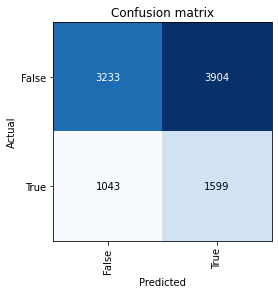

In [89]:
interp.plot_confusion_matrix()

In [90]:
learn.save("tabular")

Path('models/tabular.pth')

In [91]:
learn = learn.load("tabular")

In [92]:
test_df = pd.read_csv("../data/processed/test/data.csv", low_memory=False)
dl = learn.dls.test_dl(test_df)

In [93]:
learn.get_preds(dl=dl)

(tensor([[0.4804, 0.5196],
         [0.4838, 0.5162],
         [0.4896, 0.5104],
         ...,
         [0.4847, 0.5153],
         [0.4948, 0.5052],
         [0.3143, 0.6857]]),
 None)

In [23]:
dist_preds = []
for i in range(4):
    preds, targs = learn.get_preds(dl=dl, cbs=[MCDropoutCallback()])
    dist_preds += [preds]

preds = torch.stack(dist_preds)

In [24]:
preds.mean(dim=0)

tensor([[0.5759, 0.4241],
        [0.5211, 0.4789],
        [0.5102, 0.4898],
        ...,
        [0.4779, 0.5221],
        [0.4473, 0.5527],
        [0.9834, 0.0166]])

In [27]:
# decision tree
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [28]:
def rf(
    xs,
    y,
    n_estimators=40,
    max_samples=train_len,
    max_features=0.5,
    min_samples_leaf=5,
    **kwargs
):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True,
    ).fit(xs, y)


m = rf(xs, y);

In [29]:
m

RandomForestRegressor(max_features=0.5, max_samples=19856, min_samples_leaf=5,
                      n_estimators=40, n_jobs=-1, oob_score=True)